## try

data prep

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# load MNIST dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

mnist_train = MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = MNIST(root='./data', train=False, transform=transform, download=True)

# create data loaders
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno -3] Temporary failure in name resolution>



100%|██████████| 9912422/9912422 [00:03<00:00, 3157355.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 28881/28881 [00:00<00:00, 648016.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 1648877/1648877 [00:00<00:00, 4520672.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 4542/4542 [00:00<00:00, 11319387.27it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



model prep

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

generate embeddings and classify

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Process images through the processor (resize & normalization)
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        image_features = model.get_image_features(**inputs)

        # Prepare text prompts and encode them
        text_prompts = [f"a photo of a {i}" for i in range(10)]
        text_inputs = processor(text=text_prompts, return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**text_inputs)

        # Calculate similarities and predictions
        similarities = torch.einsum("nd,md->nm", image_features, text_features)
        # similarities = torch.nn.functional.cosine_similarity(image_features, text_features)
        # similarities: a list of probabilities for the 9 classes
        predictions = similarities.argmax(dim=1)
        print("predictions", predictions)
        print("labels", labels)

        correct += (predictions == labels).sum().item()
        print(f"correct: {correct}")
        total += labels.size(0)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


predictions tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')
correct: 10
predictions tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels tensor([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
        6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7,
        3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5], device='cuda:0')
correct: 15
pr

evaluate

In [ ]:
accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 11.35%


## simple clip api



dataset loading

11490434/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


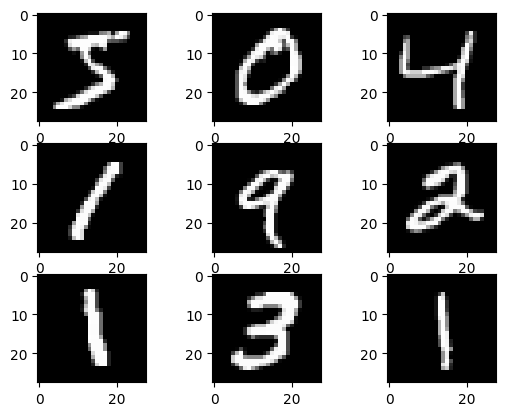

In [ ]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

try with one image

In [ ]:
pip install tqdm

In [ ]:
import numpy as np
import torch

from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

correct, total = 0, 0

# pyplot.imshow(train_X[7], cmap=pyplot.get_cmap('gray'))
# print(train_y[7])

text_prompts = [f"a photo of a {i}" for i in range(10)]

for i in tqdm(range(10000)):
  image_with_channel = np.expand_dims(train_X[i], axis=0)
  image_tensor = torch.tensor(image_with_channel, dtype=torch.float).to(device)
  image_tensor_rgb = image_tensor.repeat(3, 1, 1)

  inputs = processor(text=text_prompts, images=image_tensor_rgb, return_tensors="pt", padding=True)
  inputs = {k: v.to(device) for k, v in inputs.items()}
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image  # image-text similarity score

  similarities = logits_per_image.softmax(dim=1)
  predictions = similarities.argmax(dim=1)
  correct += 1 if predictions == train_y[i] else 0
  total += 1

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 10000/10000 [06:29<00:00, 25.66it/s]

Accuracy: 25.06%


## most recent

In [ ]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-k0yw013i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-k0yw013i
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_cur

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
import clip
import os
from torchvision.datasets import MNIST
import numpy as np

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

labels = ['0','1','2','3','4','5','6','7','8','9',]
prompt_templates = ['a photo of the number: "{}".',]

@torch.no_grad()
def evaluate(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())

    return res

@torch.no_grad()
def evaluate_with_ranks(output, target, topk=(1,)):
    # Number of classes could be determined from the size of the second dimension of output
    num_classes = output.shape[1]
    batch_size = target.size(0)

    # Get the top 'num_classes' indices of the predictions (sorted by highest probability)
    _, pred_full = output.topk(num_classes, 1, True, True)
    pred_full = pred_full.t()

    # Calculate the top 'maxk' accuracies as before
    maxk = max(topk)
    _, pred_topk = output.topk(maxk, 1, True, True)
    pred_topk = pred_topk.t()
    correct_topk = pred_topk.eq(target.view(1, -1).expand_as(pred_topk))

    res = []
    full_ranks = []
    for i in range(batch_size):
        # Finding the full rank of the correct class for each sample from the full predictions
        full_rank = (pred_full[:, i] == target[i]).nonzero(as_tuple=True)[0] + 1
        full_ranks.append(full_rank.item())

    for k in topk:
        # Calculate correct predictions within top k from the limited topk predictions
        correct_k = correct_topk[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())

    return res, full_ranks

@torch.no_grad()
def extract_text_features():
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for label in labels:
        texts = [prompt.format(label) for prompt in prompt_templates]
        print(texts)
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
import os

dataset = MNIST(root=os.path.expanduser("~/.cache"), download=True, train=False)
model, preprocess = clip.load('RN50', device)

image_features = []
image_labels = []
for image, class_id in dataset:
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image_input)
    image_feature /= image_feature.norm()
    image_features.append(image_feature)
    image_labels.append(class_id)
image_features = torch.stack(image_features, dim=1).to(device)
image_features = image_features.squeeze()

# extract text feature
text_features = extract_text_features()

# compute top-1 accuracy
clip_logits = (100. * image_features @ text_features).softmax(dim=-1)
clip_image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)
# top1_acc, top3_acc, top5_acc = evaluate(logits, image_labels, topk=(1, 3, 5))
# # print(f'top-1 accuracy for MNIST dataset: {top1_acc[0]:.3f}')
# # print(f'top-5 accuracy for MNIST dataset: {top5_acc[0]:.3f}')
# print(f'top-1 accuracy for MNIST dataset: {top1_acc:.3f}')
# print(f'top-3 accuracy for MNIST dataset: {top3_acc:.3f}')
# print(f'top-5 accuracy for MNIST dataset: {top5_acc:.3f}')
clip_accuracies, clip_ranks = evaluate_with_ranks(clip_logits, clip_image_labels)
print(f'top-1 accuracy for MNIST dataset: {clip_accuracies[0]:.3f}')

Failed to download (trying next):
<urlopen error [Errno -3] Temporary failure in name resolution>



100%|██████████| 9912422/9912422 [00:00<00:00, 16595891.17it/s]


Extracting /root/.cache/MNIST/raw/train-images-idx3-ubyte.gz to /root/.cache/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 491991.53it/s]


Extracting /root/.cache/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.cache/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 1648877/1648877 [00:00<00:00, 4405792.47it/s]


Extracting /root/.cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.cache/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 4542/4542 [00:00<00:00, 7506118.51it/s]


Extracting /root/.cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.cache/MNIST/raw



100%|███████████████████████████████████████| 244M/244M [00:02<00:00, 99.7MiB/s]


['a photo of the number: "0".']
['a photo of the number: "1".']
['a photo of the number: "2".']
['a photo of the number: "3".']
['a photo of the number: "4".']
['a photo of the number: "5".']
['a photo of the number: "6".']
['a photo of the number: "7".']
['a photo of the number: "8".']
['a photo of the number: "9".']
top-1 accuracy for MNIST dataset: 57.740


In [ ]:
print(text_features.shape)
print(image_features.shape)

print(text_features[0])

# compute top-1 accuracy
clip_logits = (100. * image_features @ text_features).softmax(dim=-1)
clip_image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)
# top1_acc, top3_acc, top5_acc = evaluate(logits, image_labels, topk=(1, 3, 5))
# # print(f'top-1 accuracy for MNIST dataset: {top1_acc[0]:.3f}')
# # print(f'top-5 accuracy for MNIST dataset: {top5_acc[0]:.3f}')
# print(f'top-1 accuracy for MNIST dataset: {top1_acc:.3f}')
# print(f'top-3 accuracy for MNIST dataset: {top3_acc:.3f}')
# print(f'top-5 accuracy for MNIST dataset: {top5_acc:.3f}')
clip_accuracies, clip_ranks = evaluate_with_ranks(clip_logits, clip_image_labels)
print(f'top-1 accuracy for MNIST dataset: {clip_accuracies[0]:.3f}')

torch.Size([1024, 10])
torch.Size([10000, 1024])
tensor([0.0074, 0.0243, 0.0262, 0.0130, 0.0099, 0.0207, 0.0178, 0.0375, 0.0074,
        0.0101], device='cuda:0', dtype=torch.float16)
top-1 accuracy for MNIST dataset: 57.740


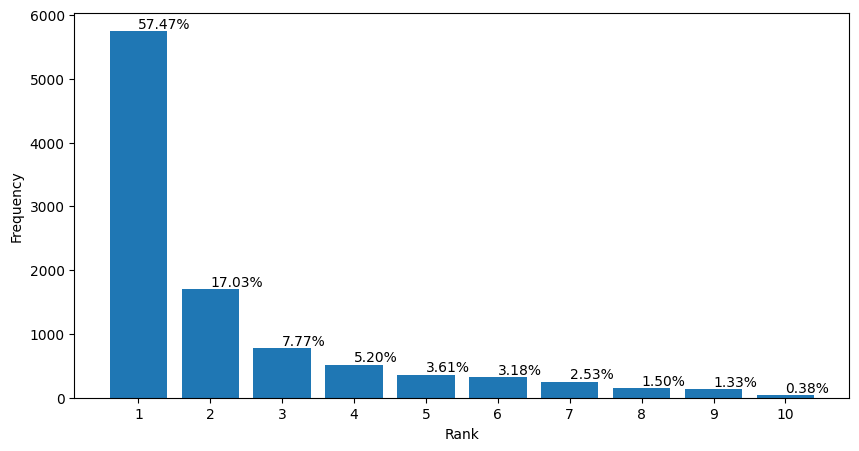

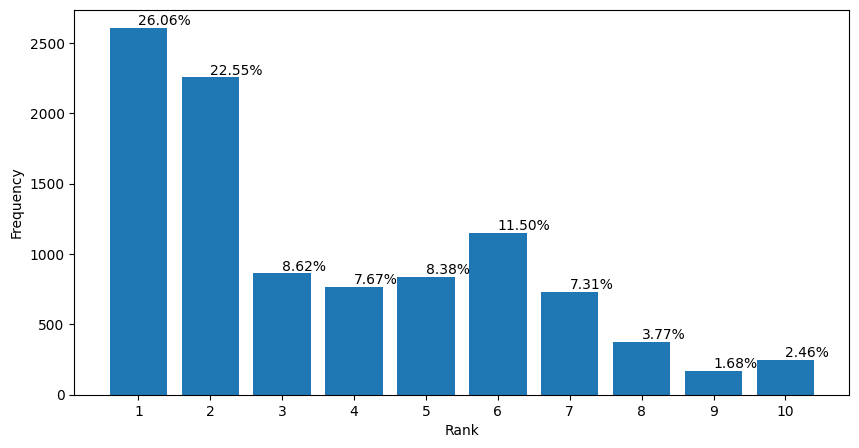

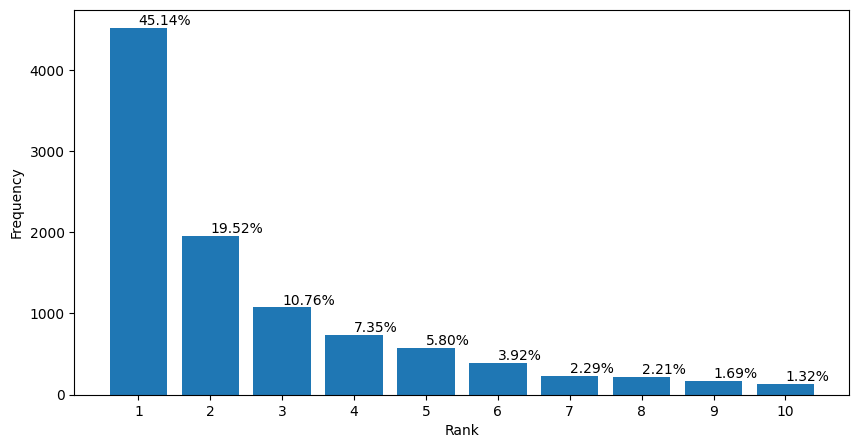

In [ ]:
plot_ranks(clip_ranks)
plot_ranks(llm_ranks)
plot_ranks(clip_llm_ranks)


# LLM version

In [ ]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-txbtkqzo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-txbtkqzo
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
import clip
import os
from torchvision.datasets import  MNIST, CIFAR10
import numpy as np

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

labels = ['0','1','2','3','4','5','6','7','8','9',]
prompt_templates = ['a photo of the number: "{}".',]

# GPT descriptions
descriptions = {'0': "The number 0 is typically represented as a circle or oval shape. It has a closed loop without any line segments protruding from the shape. The circle is uniform in thickness around its perimeter. There are no internal features within the circle; it is a solid shape.",
                '1': "The number 1 is characterized by a single vertical line. The line is usually straight, extending from the top to the bottom of the visual field. It may have a slight slant or tilt depending on the style of handwriting. The line is typically uniform in thickness from top to bottom.",
                '2': "The number 2 consists of two curved shapes. The top part of the number resembles a backward C or a flattened semicircle. The bottom part extends from the midpoint of the top curve and curves outward to the right, resembling a mirrored S shape.",
                '3': "The number 3 is characterized by a combination of curved and straight lines. It begins with a rounded shape similar to a backward C or a semicircle, but with a slight protrusion to the right. From the midpoint of this shape, a diagonal line extends downward and curves slightly to the right, resembling a mirrored 'L' shape.",
                '4': "The number 4 is defined by a combination of straight and curved lines. It begins with a vertical line that extends downward from the top of the visual field. At the midpoint of this line, a horizontal line extends to the right, forming a right angle with the vertical line.",
                '5': "The number 5 consists of a combination of curved and straight lines. It begins with a vertical line that extends downward from the top of the visual field. At the midpoint of this line, a curved line extends outward to the right, resembling a mirrored S shape.",
                '6': "The number 6 is characterized by a combination of curved and straight lines. It begins with a vertical line that extends downward from the top of the visual field. At the midpoint of this line, a curved line extends outward to the right and then curves back inward, resembling a backward C shape.",
                '7': "The number 7 is defined by a combination of straight and curved lines. It begins with a short horizontal line that extends to the right from the top of the visual field. From the midpoint of this line, a diagonal line extends downward and curves slightly to the right, resembling a mirrored L shape.",
                '8': "The number 8 is typically represented as a pair of symmetrical circles or ovals. The circles are closed loops without any line segments protruding from the shapes. They are uniform in thickness around their perimeters and are typically of the same size. There are no internal features within the circles; they are solid shapes.",
                '9': "The number 9 is characterized by a combination of curved and straight lines. It begins with a short horizontal line that extends to the right from the top of the visual field. From the midpoint of this line, a diagonal line extends downward and curves slightly to the left, resembling a mirrored L shape."}

descriptions_2 = {'0': "Number 0: A closed loop shape with uniform thickness around its perimeter.",
                  '1': "Number 1: A single vertical line with uniform thickness from top to bottom.",
                  '2': "Number 2: Two curved shapes, resembling a backward C and a mirrored S, with smooth and uniform curves.",
                  '3': "Number 3: A rounded shape resembling a backward C with a diagonal line extending downward and curving slightly to the right.",
                  '4': "Number 4: A vertical line extending downward with a horizontal line extending to the right, forming a right angle.",
                  '5': "Number 5: A vertical line with a curved line extending outward to the right, resembling a mirrored S, with smooth curves.",
                  '6': "Number 6: A vertical line with a curved line extending outward to the right and curving back inward, resembling a backward C.",
                  '7': "Number 7: A short horizontal line extending to the right with a diagonal line extending downward and curving slightly to the right.",
                  '8': "Number 8: A pair of symmetrical closed loops or circles with uniform thickness around their perimeters.",
                  '9': "Number 9: A short horizontal line extending to the right with a diagonal line extending downward and curving slightly to the left."}

@torch.no_grad()
def evaluate(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

@torch.no_grad()
def extract_text_features():
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for label in labels:
        texts = [descriptions_2[label]]
        print(texts)
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights

In [ ]:
import os

dataset = MNIST(root=os.path.expanduser("~/.cache"), download=True, train=False)
model, preprocess = clip.load('RN50', device)

In [ ]:
image_features = []
image_labels = []
for image, class_id in dataset:
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image_input)
    image_feature /= image_feature.norm()
    image_features.append(image_feature)
    image_labels.append(class_id)
image_features = torch.stack(image_features, dim=1).to(device)
image_features = image_features.squeeze()

# extract text feature
text_features = extract_text_features()

# compute top-1 accuracy
llm_logits = (100. * image_features @ text_features).softmax(dim=-1)
llm_image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)
# top1_acc, top3_acc, top5_acc = evaluate(logits, image_labels, (1, 3, 5))
# print(f'top-1 accuracy for MNIST dataset: {top1_acc:.3f}')
# print(f'top-3 accuracy for MNIST dataset: {top3_acc:.3f}')
# print(f'top-5 accuracy for MNIST dataset: {top5_acc:.3f}')
llm_accuracies, llm_ranks = evaluate_with_ranks(llm_logits, llm_image_labels)

['Number 0: A closed loop shape with uniform thickness around its perimeter.']
['Number 1: A single vertical line with uniform thickness from top to bottom.']
['Number 2: Two curved shapes, resembling a backward C and a mirrored S, with smooth and uniform curves.']
['Number 3: A rounded shape resembling a backward C with a diagonal line extending downward and curving slightly to the right.']
['Number 4: A vertical line extending downward with a horizontal line extending to the right, forming a right angle.']
['Number 5: A vertical line with a curved line extending outward to the right, resembling a mirrored S, with smooth curves.']
['Number 6: A vertical line with a curved line extending outward to the right and curving back inward, resembling a backward C.']
['Number 7: A short horizontal line extending to the right with a diagonal line extending downward and curving slightly to the right.']
['Number 8: A pair of symmetrical closed loops or circles with uniform thickness around their 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%matplotlib inline

def plot_ranks(ranks, model):
  counter = Counter(ranks)

  numbers = list(counter.keys())
  frequencies = list(counter.values())
  total = sum(counter.values())
  percentages = [f"{(count / total) * 100:.2f}%" for count in frequencies]

  plt.figure(figsize=(10, 5))  # Optional: specifies the figure size
  bars = plt.bar(numbers, frequencies)  # Creates a bar chart
  plt.xlabel('Distribution')  # Label for the x-axis
  plt.ylabel('Frequency')  # Label for the y-axis
  plt.title("Prediction Frequency Distribution of " + model)
  plt.xticks(numbers)

  for bar, percentage in zip(bars, percentages):
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval, percentage, va='bottom')

  plt.show()

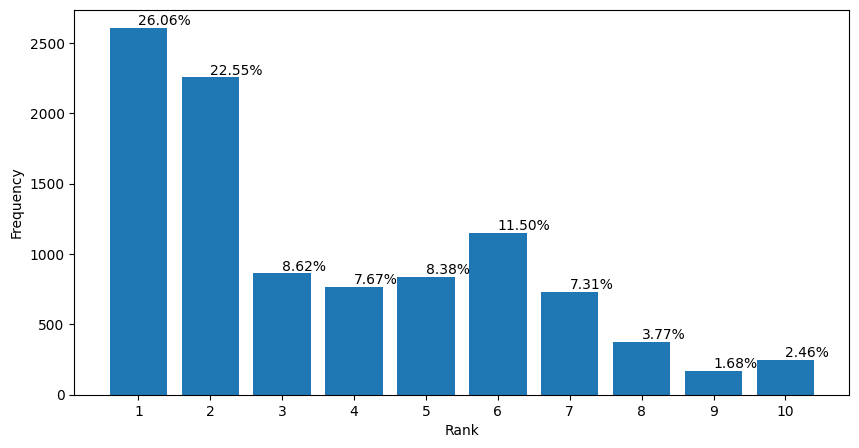

In [ ]:
plot_ranks(llm_ranks)

In [ ]:
clip_llm_logits = clip_logits + llm_logits
clip_llm_accuracies, clip_llm_ranks = evaluate_with_ranks(clip_llm_logits, llm_image_labels)

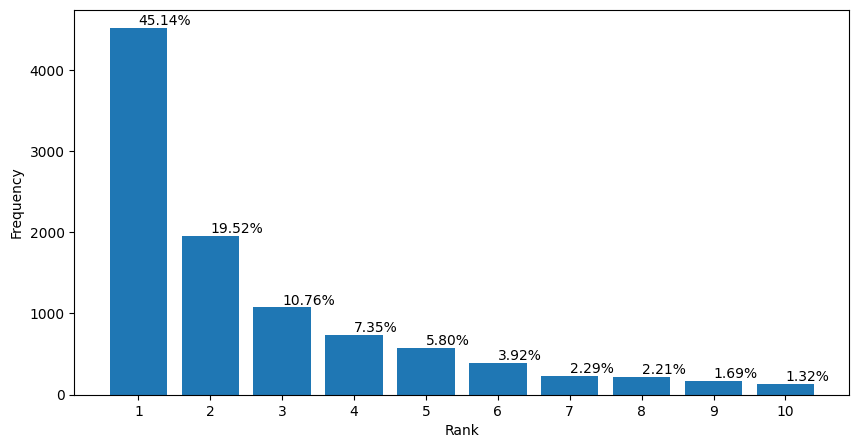

In [ ]:
plot_ranks(clip_llm_ranks)

In [ ]:
# print(clip_accuracies, llm_accuracies, clip_llm_accuracies)
print(llm_image_labels == clip_image_labels)

tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]], device='cuda:0')


# Top-3 + LLM

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import os

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

dataset = MNIST(root=os.path.expanduser("~/.cache"), download=True, train=False)
model, preprocess = clip.load('RN50', device)

# Basic and detailed descriptions for each digit
basic_prompts = ['a photo of the number: "{}".'.format(i) for i in range(10)]
detailed_descriptions = {
    '0': "a photo of the number: A closed loop shape with uniform thickness around its perimeter.",
    '1': "a photo of the number: A single vertical line with uniform thickness from top to bottom.",
    '2': "a photo of the number: Two curved shapes, resembling a backward C and a mirrored S, with smooth and uniform curves.",
    '3': "a photo of the number: A rounded shape resembling a backward C with a diagonal line extending downward and curving slightly to the right.",
    '4': "a photo of the number: A vertical line extending downward with a horizontal line extending to the right, forming a right angle.",
    '5': "a photo of the number: A vertical line with a curved line extending outward to the right, resembling a mirrored S, with smooth curves.",
    '6': "a photo of the number: A vertical line with a curved line extending outward to the right and curving back inward, resembling a backward C.",
    '7': "a photo of the number: A short horizontal line extending to the right with a diagonal line extending downward and curving slightly to the right.",
    '8': "a photo of the number: A pair of symmetrical closed loops or circles with uniform thickness around their perimeters.",
    '9': "a photo of the number: A short horizontal line extending to the right with a diagonal line extending downward and curving slightly to the left."
}

##
def extract_text_features():
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for label in labels:
        texts = [prompt.format(label) for prompt in prompt_templates]
        print(texts)
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights
##

# Function to extract text features
def extract_text_features(prompts):
    text_inputs = processor(text=prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    text_features = model.encode_text(**text_inputs)
    text_features = text_features.last_hidden_state[:, 0, :]
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

# MNIST transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images for CLIP
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))  # Normalize images
# ])

# Load MNIST data
# dataset = MNIST(root=os.path.expanduser("~/.cache"), download=True, train=False, transform=transform)



In [ ]:
# Extract features for all images
image_features = []
labels = []

for img, label in dataset:
    img = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(img)
        # image_feature = image_feature.last_hidden_state[:, 0, :]
        image_feature /= image_feature.norm(dim=-1, keepdim=True)
    image_features.append(image_feature)
    labels.append(label)

image_features = torch.cat(image_features)  # Shape: (num_images, feature_dim)

# Initial predictions with basic prompts
basic_text_features = extract_text_features(basic_prompts)
logits = image_features @ basic_text_features.T
initial_probs = logits.softmax(dim=-1)
top3_preds = torch.topk(initial_probs, 3).indices  # Shape: (num_images, 3)

# Refine predictions using detailed descriptions
refined_predictions = []
for i, preds in enumerate(top3_preds):
    detailed_prompts = [detailed_descriptions[str(idx.item())] for idx in preds]
    detailed_text_features = extract_text_features(detailed_prompts)
    refined_logits = image_features[i].unsqueeze(0) @ detailed_text_features.T
    refined_probs = refined_logits.softmax(dim=-1)
    refined_pred = preds[refined_probs.argmax(dim=-1).item()].item()
    refined_predictions.append(refined_pred)

# Calculate refined top-1 accuracy
labels = torch.tensor(labels, device=device)
refined_top1_correct = torch.tensor(refined_predictions, device=device) == labels
refined_top1_accuracy = refined_top1_correct.float().mean().item() * 100

print(f"Refined Top-1 Accuracy: {refined_top1_accuracy:.2f}%")

TypeError: CLIP.encode_text() got an unexpected keyword argument 'input_ids'

# Sang's version of OCR + CLIP

In [30]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.9 MB/s eta 0:00:00


In [31]:
from torchvision.transforms import ToPILImage
import easyocr
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# load MNIST dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

'''mnist_data = MNIST(root='./data', train=False, transform=transform, download=True)
mnist_train = MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = MNIST(root='./data', train=False, transform=transform, download=True)

images = mnist_data.data.numpy()
images_pil = [ToPILImage()(image) for image in images]'''

mnist_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
images = mnist_dataset.data.numpy()
images_pil = np.array([ToPILImage()(image) for image in images])
#mnist_images = [image for image, _ in mnist_dataset]

# EasyOCR reader
reader = easyocr.Reader(['en'])  # Specify languages (e.g., English)

preds = []
for image in images_pil:
  results = reader.readtext(image)

  if results != []:
    preds.append(results[0][1])
  else:
    preds.append(None)

sentence_bert_model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

ModuleNotFoundError: No module named 'easyocr'

In [ ]:
preds

[]

# Heyang's OCR

In [ ]:
!pip install python-mnist

In [ ]:
!git clone https://github.com/sorki/python-mnist

Cloning into 'python-mnist'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 246 (delta 1), reused 2 (delta 0), pack-reused 240
Receiving objects: 100% (246/246), 47.14 KiB | 3.14 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [ ]:
cd python-mnist

/content/python-mnist


In [ ]:
#!bash ./bin/mnist_get_data.sh

--2024-04-05 02:35:04--  http://yann.lecun.com/exdb/mnist/
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data/index.html.tmp’

index.html.tmp          [ <=>                ]  28.49K  --.-KB/s    in 0s      

2024-04-05 02:35:04 (177 MB/s) - ‘data/index.html.tmp’ saved [29170]

Loading robots.txt; please ignore errors.
--2024-04-05 02:35:04--  http://yann.lecun.com/robots.txt
Reusing existing connection to yann.lecun.com:80.
HTTP request sent, awaiting response... 404 Not Found
2024-04-05 02:35:04 ERROR 404: Not Found.

Removing data/index.html.tmp since it should be rejected.

--2024-04-05 02:35:04--  http://yann.lecun.com/
Reusing existing connection to yann.lecun.com:80.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘

In [ ]:
!PYTHONPATH=. ./bin/mnist_preview


/content/python-mnist/mnist/loader.py:179: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.return_type is 'lists':
/content/python-mnist/mnist/loader.py:181: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.return_type is 'numpy':
/content/python-mnist/mnist/loader.py:187: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.return_type is 'lists':
/content/python-mnist/mnist/loader.py:189: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.return_type is 'numpy':
/content/python-mnist/mnist/loader.py:243: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if type(batch) is not list or len(batch) is not 2:
Traceback (most recent call last):
  File "/content/python-mnist/./bin/mnist_preview", line 26, in <module>
    img, label = mn.load_testing()
  File "/content/python-mnist/mnist/loader.py", line 116, in load_testing
    ims, labels = self.load(os.path.join(self.path, self.test_img_fname),
  File "/content/pytho

In [ ]:
!sudo apt install tesseract-ocr
!pip -q install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,020 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
!sudo apt install tesseract-ocr
!pip -q install pytesseract

import pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install pytesseract==0.3.9

  Attempting uninstall: pytesseract
    Found existing installation: pytesseract 0.3.10
    Uninstalling pytesseract-0.3.10:
      Successfully uninstalled pytesseract-0.3.10


In [ ]:
!pip install Pkg

In [ ]:
# Copyright 2015 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Functions for downloading and reading MNIST data."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import gzip
import os
import tensorflow.python.platform
import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
def maybe_download(filename, work_directory):
  """Download the data from Yann's website, unless it's already here."""
  if not os.path.exists(work_directory):
    os.mkdir(work_directory)
  filepath = os.path.join(work_directory, filename)
  if not os.path.exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  return filepath
def _read32(bytestream):
  dt = numpy.dtype(numpy.uint32).newbyteorder('>')
  return numpy.frombuffer(bytestream.read(4), dtype=dt)[0]
def extract_images(filename):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError(
          'Invalid magic number %d in MNIST image file: %s' %
          (magic, filename))
    num_images = _read32(bytestream)
    rows = _read32(bytestream)
    cols = _read32(bytestream)
    buf = bytestream.read(rows * cols * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    return data
def dense_to_one_hot(labels_dense, num_classes=10):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = numpy.arange(num_labels) * num_classes
  labels_one_hot = numpy.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot
def extract_labels(filename, one_hot=False):
  """Extract the labels into a 1D uint8 numpy array [index]."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    magic = _read32(bytestream)
    if magic != 2049:
      raise ValueError(
          'Invalid magic number %d in MNIST label file: %s' %
          (magic, filename))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    if one_hot:
      return dense_to_one_hot(labels)
    return labels
class DataSet(object):
  def __init__(self, images, labels, fake_data=False, one_hot=False,
               dtype=tf.float32):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.
    """
    dtype = tf.as_dtype(dtype).base_dtype
    if dtype not in (tf.uint8, tf.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape,
                                                 labels.shape))
      self._num_examples = images.shape[0]
      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      assert images.shape[3] == 1
      images = images.reshape(images.shape[0],
                              images.shape[1] * images.shape[2])
      if dtype == tf.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0
  @property
  def images(self):
    return self._images
  @property
  def labels(self):
    return self._labels
  @property
  def num_examples(self):
    return self._num_examples
  @property
  def epochs_completed(self):
    return self._epochs_completed
  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1] * 784
      if self.one_hot:
        fake_label = [1] + [0] * 9
      else:
        fake_label = 0
      return [fake_image for _ in xrange(batch_size)], [
          fake_label for _ in xrange(batch_size)]
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]
def read_data_sets(train_dir, fake_data=False, one_hot=False, dtype=tf.float32):
  class DataSets(object):
    pass
  data_sets = DataSets()
  if fake_data:
    def fake():
      return DataSet([], [], fake_data=True, one_hot=one_hot, dtype=dtype)
    data_sets.train = fake()
    data_sets.validation = fake()
    data_sets.test = fake()
    return data_sets
  TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
  TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
  TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
  TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
  VALIDATION_SIZE = 5000
  local_file = maybe_download(TRAIN_IMAGES, train_dir)
  train_images = extract_images(local_file)
  local_file = maybe_download(TRAIN_LABELS, train_dir)
  train_labels = extract_labels(local_file, one_hot=one_hot)
  local_file = maybe_download(TEST_IMAGES, train_dir)
  test_images = extract_images(local_file)
  local_file = maybe_download(TEST_LABELS, train_dir)
  test_labels = extract_labels(local_file, one_hot=one_hot)
  validation_images = train_images[:VALIDATION_SIZE]
  validation_labels = train_labels[:VALIDATION_SIZE]
  train_images = train_images[VALIDATION_SIZE:]
  train_labels = train_labels[VALIDATION_SIZE:]
  data_sets.train = DataSet(train_images, train_labels, dtype=dtype)
  data_sets.validation = DataSet(validation_images, validation_labels,
                                 dtype=dtype)
  data_sets.test = DataSet(test_images, test_labels, dtype=dtype)
  return data_sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# %cd MyDrive/trainingSample
!cp -r /content/drive/MyDrive/trainingSample /content

cp: cannot stat '/content/drive/MyDrive/trainingSample': No such file or directory


Step1: Load Data

In [ ]:
import os
from transformers import CLIPProcessor, CLIPModel
import torch
import os
from torchvision.datasets import  MNIST, CIFAR10
import numpy as np
# import easyocr
from keras.datasets import mnist
from mnist import MNIST
import pytesseract
import cv2
from PIL import Image

# reader = easyocr.Reader(['ch_sim','en'])
class_folders = os.listdir('/content/python-mnist/data')
class_to_label = {class_folder: index for index, class_folder in enumerate(class_folders)}

images = []
labels = []

(train_X, train_y), (test_X, test_y) = mnist.load_data()

class_path = '/content/trainingSample'

cnt = 0

for image_filename in os.listdir(class_path):
      if (cnt >= 5):
        break
      if (image_filename != 'trainingSample'):
        image_path = os.path.join(class_path, image_filename)
        print(image_filename)
        print(image_path)
        # Open the image and convert it to grayscale if needed
        image = Image.open(image_path)
        images.append(image)
        cnt = cnt + 1


# d = {label: labels.count(label) for label in labels}
# d
# images = []
# labels = []

# mndata = MNIST('/content/python-mnist/data')
# images, labels = mndata.load_training()
# img = []

# TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
# train_dir = '/content/python-mnist/data'
# local_file = maybe_download(TRAIN_IMAGES, train_dir)
# train_images = extract_images(local_file)
# train_images
# for image in images:
#   img_t = cv2.imread(image)
#   img.append(img_t)




FileNotFoundError: [Errno 2] No such file or directory: '/content/python-mnist/data'

Step2: Image to Text - OCR IMPLEMENTATION

In [ ]:
# Function to extract text from images using Tesseract OCR
def extract_text_from_images(images):
    extracted_texts = []
    for image in images:
        extracted_text = pytesseract.image_to_string(image)
        extracted_texts.append(extracted_text)
    return extracted_texts

In [ ]:
extracted_text = extract_text_from_images(images)
extracted_text

['\x0c', '\x0c', '\x0c', '\x0c', '\x0c']

Example

In [ ]:
!pip install tensorflow


In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 31.6 MB/s eta 0:00:00


In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
import easyocr
import os
# from keras.datasets import mnist
reader = easyocr.Reader(['ch_sim','en'])
path = '/content/img_10.jpg'
print(reader.readtext(path, detail = 0))
print(reader.readtext('/content/trainingSample/img_100.jpg', detail = 0))
# image_t = Image.open(path)
# text = pytesseract.image_to_string(image_t)
print(reader.readtext('/content/img_99.jpg', detail = 0))
class_path = '/content/trainingSample'
cnt = 0
for file_name in os.listdir(class_path):
  if(cnt >= 10):
    break
  if (file_name != 'trainingSample'):
    image_path = os.path.join(class_path, file_name)
    print(file_name)
    print(image_path)
    print(reader.readtext(image_path, detail = 0))
    cnt = cnt + 1


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

FileNotFoundError: No such file: '/content/img_10.jpg'

In [ ]:
from matplotlib import pyplot
# pyplot.imshow(train_X[0])

# extracted_texts = extract_text_from_images(train_X[300])
extracted_text = pytesseract.image_to_string(train_X[0])
extracted_text

In [ ]:
import easyocr
from keras.datasets import mnist
reader = easyocr.Reader(['ch_sim','en']) # this needs to run only once to load the model into memory
# result = reader.readtext('d3.jpg')
# reader.readtext('d3.jpg', detail = 0)
# reader.readtext('img_1.jpg', detail = 0)
reader.readtext('img_10.jpg', detail = 0)
reader.readtext('img_11.jpg', detail = 0)
reader.readtext('img_12.jpg', detail = 0)
# reader.readtext('img_13.jpg', detail = 0)

FileNotFoundError: No such file: '/content/python-mnist/img_10.jpg'

In [ ]:
!mv /content/trainingSample/img_10.jpg /content

SENTENCE BERT TEXT ENCODER

In [ ]:
from transformers import BertConfig, BertModel

# Initializing a BERT google-bert/bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the google-bert/bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config

OCR + BERT MODEL

In [ ]:
from transformers import AutoTokenizer, BertModel
import torch
import easyocr
from keras.datasets import mnist
reader = easyocr.Reader(['ch_sim','en'])

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")

inputs = tokenizer(reader.readtext('img_10.jpg', detail = 0), return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Bert Model Training

Resources:
https://github.com/yesdeepakmittal/document-classification-using-bert/blob/main/document_classification_using_bert.ipynb
https://gist.github.com/awjuliani/1d21151bc17362bf6738c3dc02f37906
https://i-systems.github.io/teaching/DL/iNotes/05_ANN_03.html
https://chromium.googlesource.com/external/github.com/tensorflow/tensorflow/+/r0.7/tensorflow/g3doc/tutorials/mnist/download/index.md
https://github.com/UKPLab/sentence-transformers


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize and train BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
epochs = 10
learning_rates = [1e-5, 5e-5, 1e-4]
optimizers = ['AdamW', 'Adam']
best_val_loss = np.inf
best_model_path = None
model_dir = '/content/drive/MyDrive/bert_models/'

for lr in learning_rates:
    for optimizer_name in optimizers:
        optimizer = None
        if optimizer_name == 'AdamW':
            optimizer = AdamW(model.parameters(), lr=lr)
        elif optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        else:
            raise ValueError("Unsupported optimizer!")

        early_stopping_counter = 0
        for epoch in range(epochs):
            model.train()
            for batch in train_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    val_loss += outputs.loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f'Epoch {epoch + 1}/{epochs}, LR: {lr}, Optimizer: {optimizer_name}, Loss: {avg_val_loss}')

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_path = model_dir + f'bert_document_classification_model_lr{lr}_{optimizer_name}.pt'
                torch.save(model.state_dict(), best_model_path)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= 3:
                    print("Early stopping triggered!")
                    break

print(f"Best model saved at: {best_model_path}")

IndentationError: expected an indented block after 'for' statement on line 53 (<ipython-input-1-65ff28d25232>, line 54)

# Sang's OCR

In [33]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
import numpy as np

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten").to(device)

# load MNIST dataset
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])


mnist_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
#images = mnist_dataset.data.numpy()

pred = []
for image in tqdm(mnist_dataset):
    image_np = image[0].permute(1, 2, 0).numpy()
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8))

    pixel_values = processor(image_pil, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values.to(device))
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    pred.append(generated_text[0])

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 9912422/9912422 [00:03<00:00, 3187103.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 28881/28881 [00:00<00:00, 484690.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4391864.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6564620.53it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 10000/10000 [26:16<00:00,  6.34it/s]


In [35]:
from sentence_transformers import SentenceTransformer

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

sentence_bert_model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

labels = [str(i) for i in range(10)]
ocr_embeddings = sentence_bert_model.encode(pred)
true_label_embeddings = sentence_bert_model.encode(labels)

similarities = cosine_similarity(ocr_embeddings, true_label_embeddings)

probabilities = torch.softmax(torch.tensor(similarities), dim=1)

preds = probabilities.argmax(dim = 1)
true_labels = np.array([image[1] for image in mnist_dataset])
(np.array(preds) == true_labels).mean()

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

OSError: Can't load tokenizer for 'sentence-transformers/bert-base-nli-mean-tokens'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'sentence-transformers/bert-base-nli-mean-tokens' is the correct path to a directory containing all relevant files for a BertTokenizerFast tokenizer.

In [ ]:
# OCR alone (llm_image_labels is from )
ocr_accuracies, ocr_ranks = evaluate_with_ranks(probabilities.to(device), labels)

plot_ranks(ocr_ranks)

In [ ]:
# CLIP + OCR
clip_ocr_logits = clip_logits.to(device) + probabilities.to(device)
clip_ocr_accuracies, clip_ocr_ranks = evaluate_with_ranks(clip_ocr_logits, llm_image_labels)

plot_ranks(clip_ocr_ranks, "CLIP + OCR")